# Mix the parents

* Primitives: ['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity']
* [Kaggle Run]()
* Best Accuracy: 
* Best Configuration:

|Block|Normal|Reduction|
|:-:|-|-|
|1.|`[1 1 2 2 1]`|`[1 0 2 2 1]`|
|2.|`[1 0 5 3 0]`|`[1 0 2 3 0]`|
|3.|`[0 1 2 4 1]`|`[0 1 1 0 1]`|
|4.|`[1 1 4 1 0]`|`[0 1 4 4 0]`|
|5.|`[0 0 5 1 0]`|`[0 0 2 0 1]`|

<img src=''>

## Installation

In [1]:
# ! pip install -q git+https://github.com/EfficientDL/codelab_utils.git

In [2]:
import random
import seaborn

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import codelab_utils.mpl_styles as mpl_styles
import networkx as nx

from tensorflow.keras import layers, losses, models, optimizers
from matplotlib import pyplot as plt
from matplotlib import ticker
from collections import deque
from random import sample, shuffle, randrange
from math import floor
from functools import reduce

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [2]:
DATASET_PARAMS = dict(
    input_shape=(32, 32, 3),
    n_classes=10,
    baseline_accuracy=.1,
    train_batch_size=128
)

train_ds, val_ds = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[20%:]'],
    as_supervised=True
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-18 16:52:50.941570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 16:52:50.943134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2022-11-18 16:52:54.098202: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-18 16:52:54.124165: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


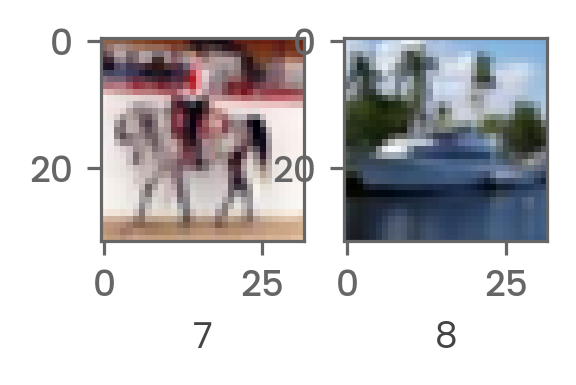

In [3]:
def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, item in enumerate(display_list):
        image, label = item
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))
        axis.set_xlabel(label)

items = []
for item in train_ds.take(2).as_numpy_iterator():
    items.append(item)

display(items, size=(2,2))

In [4]:
CHILD_PARAMS = dict(
    epochs=1,
    batch_size=DATASET_PARAMS['train_batch_size'],
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]
BLOCK_TIMESTEPS = 5

TDS = CHILD_PARAMS['train_ds'].shuffle(
    500,
    reshuffle_each_iteration=True
).batch(CHILD_PARAMS['batch_size']).take(2)
VDS = CHILD_PARAMS['val_ds'].batch(256).take(2)

class CNNCell():
    """
    It composes a cell based on the input configuration.
    Arguments:
        stride: A positive integer to represent the convolution strides.
            Normal cells use stride=1 and reduction cells use stride=2
    """
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
        """
        This method sends the input through a convolution layer with
        a fixed channel size to ensure that the inputs to each cell block
        have identical channel dimensions.
        """
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
        """
        It transforms the input branches to an identical feature space.
        It is useful when a cell receives inputs with different feature spaces.
        """
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
        """
        It halves the input feature space using a convolution layer with stride 2
        """
        if self.stride == 2:
            inputs = list(
                map(
                    lambda inp: layers.Conv2D(
                        self.channels,
                        3,
                        strides=(2,2),
                        padding='same'
                    )(inp),
                    inputs
                )
            )
        
        return inputs
    
    def apply_op(self, op_id, inp):
        """
        It applies a primitive operation to the input.
        """
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        """
        It applies a combination operation to the inputs.
        """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
        """
        It constructs a cell based on the cell_config and the branches.
        A cell_config is 2-D numpy array of shape [5,5] which contains
        the 5 state choices for each of the 5 blocks.
        """
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class MutationStrategies(object):
    def __init__(self, child_params) -> None:
        self.child_params = child_params
        self.elementary_strategies = ['point', 'block_swap']
        self.strategies = {
            'point': self.point,
            'block_swap': self.block_swap,
            'mixed': self.mixed,
            'gene_selection': self.gene_selection,
        }
    
    def point(self, config):
        address_shape = [self.child_params['blocks'], BLOCK_TIMESTEPS]
        mutation_address = tuple(map(randrange, address_shape))
        state_id = mutation_address[-1]
        state_space_id = STATE_ID_TO_STATE_SPACE_ID[state_id]
        mutation = randrange(len(STATE_SPACE[state_space_id]['values']))
        print(mutation_address, mutation)

        config[mutation_address] = mutation

        return config
    
    def block_swap(self, config):
        coordinates = list(map(
            randrange, [self.child_params['blocks']]*2
        ))
        config[coordinates] = config[list(reversed(coordinates))]

        return config
    
    def mixed(self, config):
        strategy_id = randrange(len(self.elementary_strategies))
        
        return self.strategies[self.elementary_strategies[strategy_id]](config)
    
    def gene_selection(self, config):
        blocks = config.shape[0]
        block_indices = list(range(blocks))
        random.shuffle(block_indices)

        # Select Genes
        selected = config[block_indices[:self.child_params['blocks']]]
        return selected

    def get(self, name='point'):
        return self.strategies[name]

class MergeStrategies(object):
    def __init__(self, selection_strategy) -> None:
        self.elementary_strategies = ['single_parent', 'two_parents']
        self.strategies = {
            'single_parent': self.single_parent,
            'two_parents': self.two_parents
        }
        self.selection_strategy = selection_strategy
    
    def single_parent(self, *parents):
        return parents[0]

    def two_parents(self, *parents):
        first, second = parents
        return np.array(list(
            map(
                lambda c: self.selection_strategy(np.concatenate(c)),
                zip(first, second)
            )
        ))
    
    def get(self, name='single_parent'):
        return self.strategies[name]

class Child(object):
    def __init__(self, config, train=True):
        self.config = config
        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]
        self.model = self.make_child()
        self.accuracy = 0.0
        self.accuracy = self.train() if train else 0
        print('Child: {} \n Accuracy: {:1.4f}'.format(
            self.config,
            self.accuracy
        ))
    
    def make_child(self):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(self.config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        # model.summary()

        return model

    def train(self):
        history = self.model.fit(
            TDS,
            validation_data=VDS,
            epochs=CHILD_PARAMS['epochs']
        )
        self.accuracy = max(history.history['val_accuracy'])

        return self.accuracy

controller_params = dict(
    episodes=2,
    population_size=2,
    sample_size=2,
    max_mutations=2,
    mutation_strategy='mixed',
    merge_strategy='two_parents',
    # mutation_size=1,
    # mutation_strategy='point'
)

CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self, params, child_params):
        self.population_size = params['population_size']
        self.population = deque(maxlen=self.population_size)
        self.histories = []
        self.sample_size = params['sample_size']
        self.best_accuracies = []
        self.params = params
        self.mutation_strategies = MutationStrategies(child_params)
        self.mutation_strategy = self.mutation_strategies.get(
            self.params['mutation_strategy']
        )
        self.merge_strategies = MergeStrategies(
            self.mutation_strategies.get('gene_selection')
        )
        self.merge_strategy = self.merge_strategies.get(
            self.params['merge_strategy']
        )
    
    def random_state(self, address):
        (_, __, state_id) = address
        return randrange(len(STATE_SPACE[state_id]['values']))

    def create_random_child(self):
        state = list(map(self.random_state, STATE_ADDRESSES))
        config = np.array(state).reshape(TIMESTEP_ADDRESS_SPACE)
        child = Child(config)
        return child

    def initialize_population(self):
        """
        It creates children as specified through the size parameter.
        Each child is trained and their history is stored.
        It should be called only once.

        Arguments:
            size: The size of the population.
        """
        def work_fn():
            self.population.extend(map(
                lambda _: self.create_random_child(),
                range(self.sample_size)
            ))
            self.histories += self.population
        
        work_fn() if not self.population else None
    
    def mutate(self, config):
        # def mutate_once():
        #     mutation_address = tuple(map(randrange, TIMESTEP_ADDRESS_SPACE))
        #     state_id = mutation_address[-1]
        #     state_space_id = STATE_ID_TO_STATE_SPACE_ID[state_id]
        #     mutation = randrange(len(STATE_SPACE[state_space_id]['values']))

        #     return mutation_address, mutation

        # def apply_mutation(config):
        #     address, mutation = mutate_once()

        #     print(address, mutation)
        #     config[address] = mutation
        #     return config
        def mutate_cell(cell_config):
            return reduce(
                lambda c,_: self.mutation_strategy(c),
                range(self.params['max_mutations']),
                cell_config
            )

        mutated_config = np.array(list(
            map(mutate_cell, config.copy())
        ))
    
        # mutated_config = reduce(
        #     lambda x,_: apply_mutation(x),
        #     range(2),
        #     config.copy())

        return mutated_config
    
    def run_cycle(self):
        # Pick random children from the population for the mutation stage
        p_sample = sample(range(len(self.population)), self.sample_size)

        # Find the best child in the sample
        sample_accuracies = list(map(
            lambda idx: self.population[idx].accuracy,
            p_sample
        ))
        best_sample = np.argmax(sample_accuracies)
        print('Best Child: {:2d} Accuracy: {:4f}'.format(
            p_sample[best_sample],
            sample_accuracies[best_sample]
        ))

        # Record the best accuracies
        population_accuracies = list(map(
            lambda item: item.accuracy,
            self.population
        ))
        self.best_accuracies.append(max(population_accuracies))

        # Mutate the best child in the sample
        best_child = self.population[p_sample[best_sample]]
        random_child = np.random.choice(list(self.population))
        merged_config = self.merge_strategy(
            best_child.config,
            random_child.config
        )
        mutated_config = self.mutate(merged_config)
        mutated_child = Child(mutated_config)

        # Update population
        print('Removal Candidate: {}\n Accuracy: {:1.5f}'.format(
            self.population[0].config,
            self.population[0].accuracy
        ))
        print('Mutation Candidate: {}\n Accuracy: {:1.5f}'.format(
            best_child.config,
            best_child.accuracy
        ))
        self.population.append(mutated_child)
                
        # Add the mutated child to the histories
        self.histories.append(mutated_child)

controller = Controller(controller_params, CHILD_PARAMS)
controller.initialize_population()

for episode in range(controller_params['episodes']):
    print('Cycle: ', episode)
    controller.run_cycle()
#     predictions = controller.predict_child(start_state)
    
    # config = np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)

    # # Evaluate the child generated by the controller
    # reward, accuracy = child_manager.get_rewards(config)
    # print(
    #     'Episode: {} Reward: {} Accuracy: {}'.format(
    #         episode,
    #         reward,
    #         accuracy
    #     )
    # )

    # # Store predicted child and its rewards
    # controller.save_trial(predictions, reward, accuracy)
    
    # # Train the Controller
    # controller.train_step()

    # # Update start_state for next episode.
    # start_state = np.array([predictions[0]])
    # tf.print('Start State:', start_state)

2022-11-18 16:52:59.625604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 2.3123 - accuracy: 0.1367

2022-11-18 16:53:02.749118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 6s 2s/step - loss: 2.3123 - accuracy: 0.1367 - val_loss: 2.2218 - val_accuracy: 0.1660


2022-11-18 16:53:03.673364: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-18 16:53:03.677331: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Child: [[[0 0 5 2 1]
  [0 0 2 3 0]
  [1 0 5 3 1]
  [0 0 3 5 1]
  [0 1 1 1 0]]

 [[0 1 0 2 1]
  [1 0 5 0 0]
  [1 0 2 2 1]
  [1 1 3 3 1]
  [1 0 0 0 0]]] 
 Accuracy: 0.1660


2022-11-18 16:53:05.875524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 5.5231 - accuracy: 0.0938

2022-11-18 16:53:08.674362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 5s 1s/step - loss: 5.5231 - accuracy: 0.0938 - val_loss: 2.8798 - val_accuracy: 0.1367


2022-11-18 16:53:09.559666: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-18 16:53:09.562712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Child: [[[0 1 5 1 0]
  [0 1 2 3 1]
  [0 1 5 1 1]
  [1 1 3 0 0]
  [0 1 3 4 1]]

 [[0 0 3 3 1]
  [1 1 5 0 0]
  [0 1 3 1 0]
  [0 1 0 1 0]
  [0 1 1 4 0]]] 
 Accuracy: 0.1367
Cycle:  0
Best Child:  0 Accuracy: 0.166016
(4, 0) 0
(2, 3) 0


2022-11-18 16:53:11.445945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 4.8270 - accuracy: 0.1367

2022-11-18 16:53:14.313804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 5s 2s/step - loss: 4.8270 - accuracy: 0.1367 - val_loss: 3.1353 - val_accuracy: 0.1133


2022-11-18 16:53:15.308402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-18 16:53:15.310629: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Child: [[[0 1 5 1 1]
  [0 0 2 3 0]
  [0 0 3 5 1]
  [0 1 5 1 0]
  [0 1 2 3 1]]

 [[1 1 3 3 1]
  [1 0 2 2 1]
  [0 1 0 0 0]
  [0 0 3 3 1]
  [1 1 5 0 0]]] 
 Accuracy: 0.1133
Removal Candidate: [[[0 0 5 2 1]
  [0 0 2 3 0]
  [1 0 5 3 1]
  [0 0 3 5 1]
  [0 1 1 1 0]]

 [[0 1 0 2 1]
  [1 0 5 0 0]
  [1 0 2 2 1]
  [1 1 3 3 1]
  [1 0 0 0 0]]]
 Accuracy: 0.16602
Mutation Candidate: [[[0 0 5 2 1]
  [0 0 2 3 0]
  [1 0 5 3 1]
  [0 0 3 5 1]
  [0 1 1 1 0]]

 [[0 1 0 2 1]
  [1 0 5 0 0]
  [1 0 2 2 1]
  [1 1 3 3 1]
  [1 0 0 0 0]]]
 Accuracy: 0.16602
Cycle:  1
Best Child:  0 Accuracy: 0.136719
(2, 0) 1
(3, 1) 1


2022-11-18 16:53:17.169859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 3.4901 - accuracy: 0.1016

2022-11-18 16:53:21.143684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 6s 2s/step - loss: 3.4901 - accuracy: 0.1016 - val_loss: 2.3894 - val_accuracy: 0.1484
Child: [[[0 1 5 1 0]
  [0 1 3 4 1]
  [1 1 5 1 1]
  [0 1 2 3 1]
  [1 1 3 0 0]]

 [[0 1 1 4 0]
  [1 1 5 0 0]
  [1 0 2 2 1]
  [0 1 0 1 0]
  [0 1 3 1 0]]] 
 Accuracy: 0.1484
Removal Candidate: [[[0 1 5 1 0]
  [0 1 2 3 1]
  [0 1 5 1 1]
  [1 1 3 0 0]
  [0 1 3 4 1]]

 [[0 0 3 3 1]
  [1 1 5 0 0]
  [0 1 3 1 0]
  [0 1 0 1 0]
  [0 1 1 4 0]]]
 Accuracy: 0.13672
Mutation Candidate: [[[0 1 5 1 0]
  [0 1 2 3 1]
  [0 1 5 1 1]
  [1 1 3 0 0]
  [0 1 3 4 1]]

 [[0 0 3 3 1]
  [1 1 5 0 0]
  [0 1 3 1 0]
  [0 1 0 1 0]
  [0 1 1 4 0]]]
 Accuracy: 0.13672


2022-11-18 16:53:22.190633: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-18 16:53:22.192878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


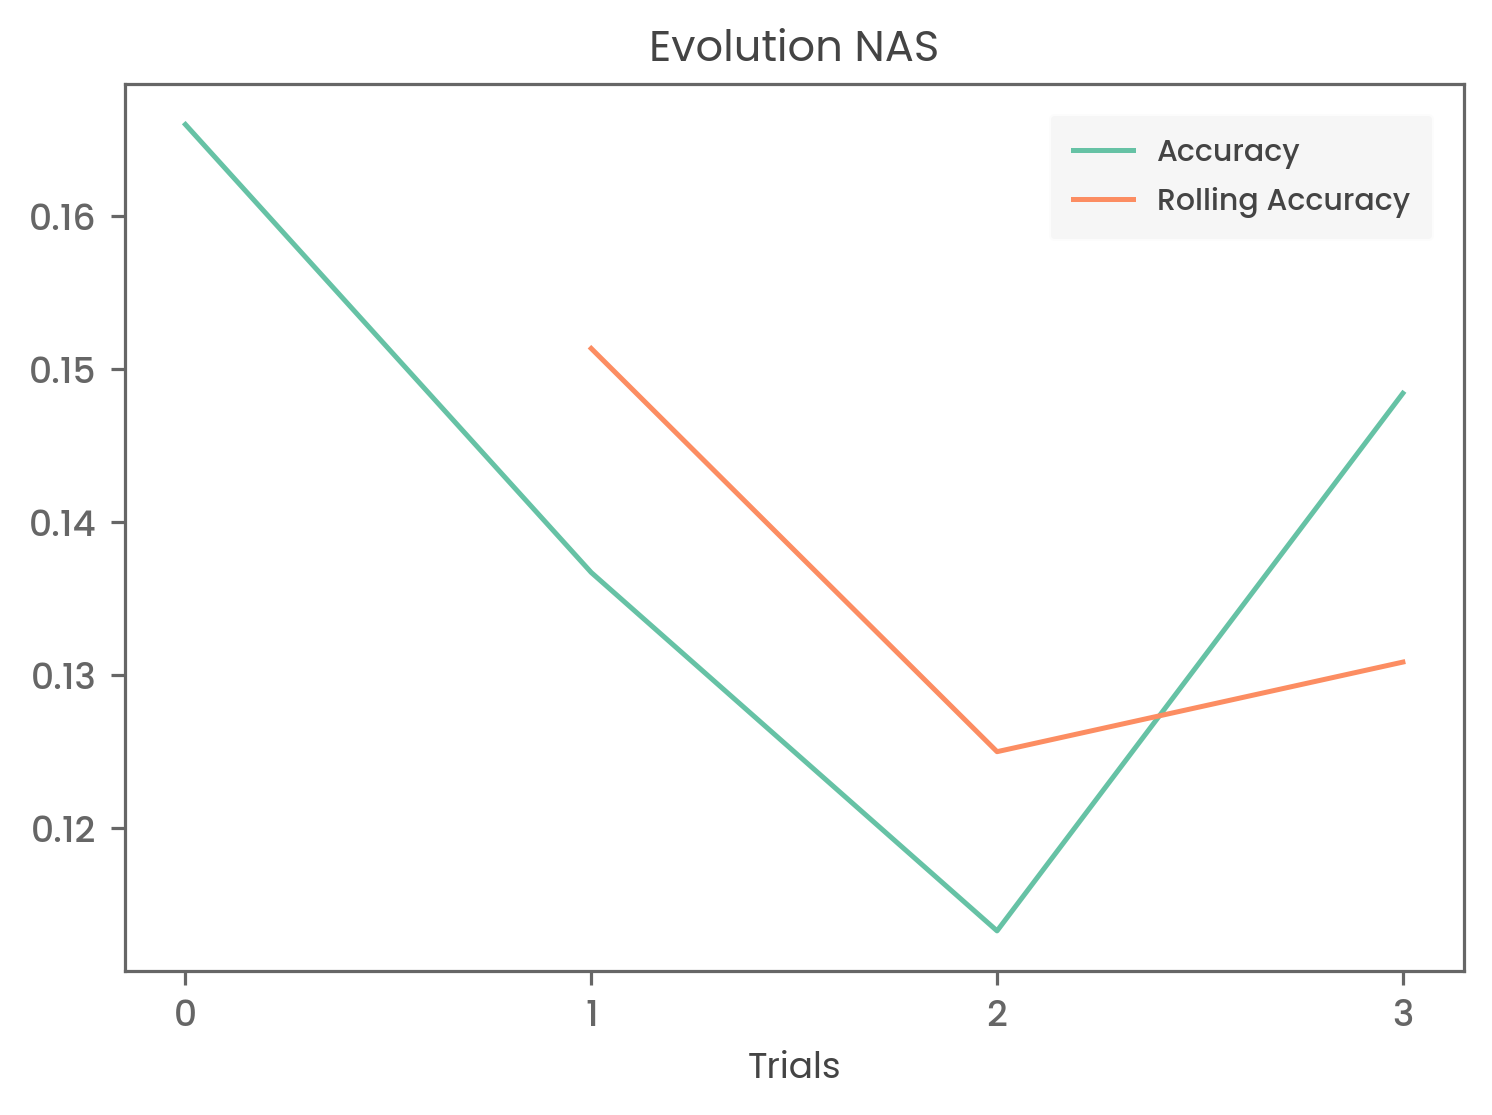

In [5]:
accuracies = list(map(lambda child: child.accuracy, controller.histories))
accuracies_df = pd.DataFrame(accuracies)
rolling_accuracies = accuracies_df.rolling(len(controller.population)).mean()[0].tolist()

plt.plot(accuracies, label='Accuracy')
axes = plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Trials')
plt.legend()
plt.title('Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

[0.166015625, 0.13671875]

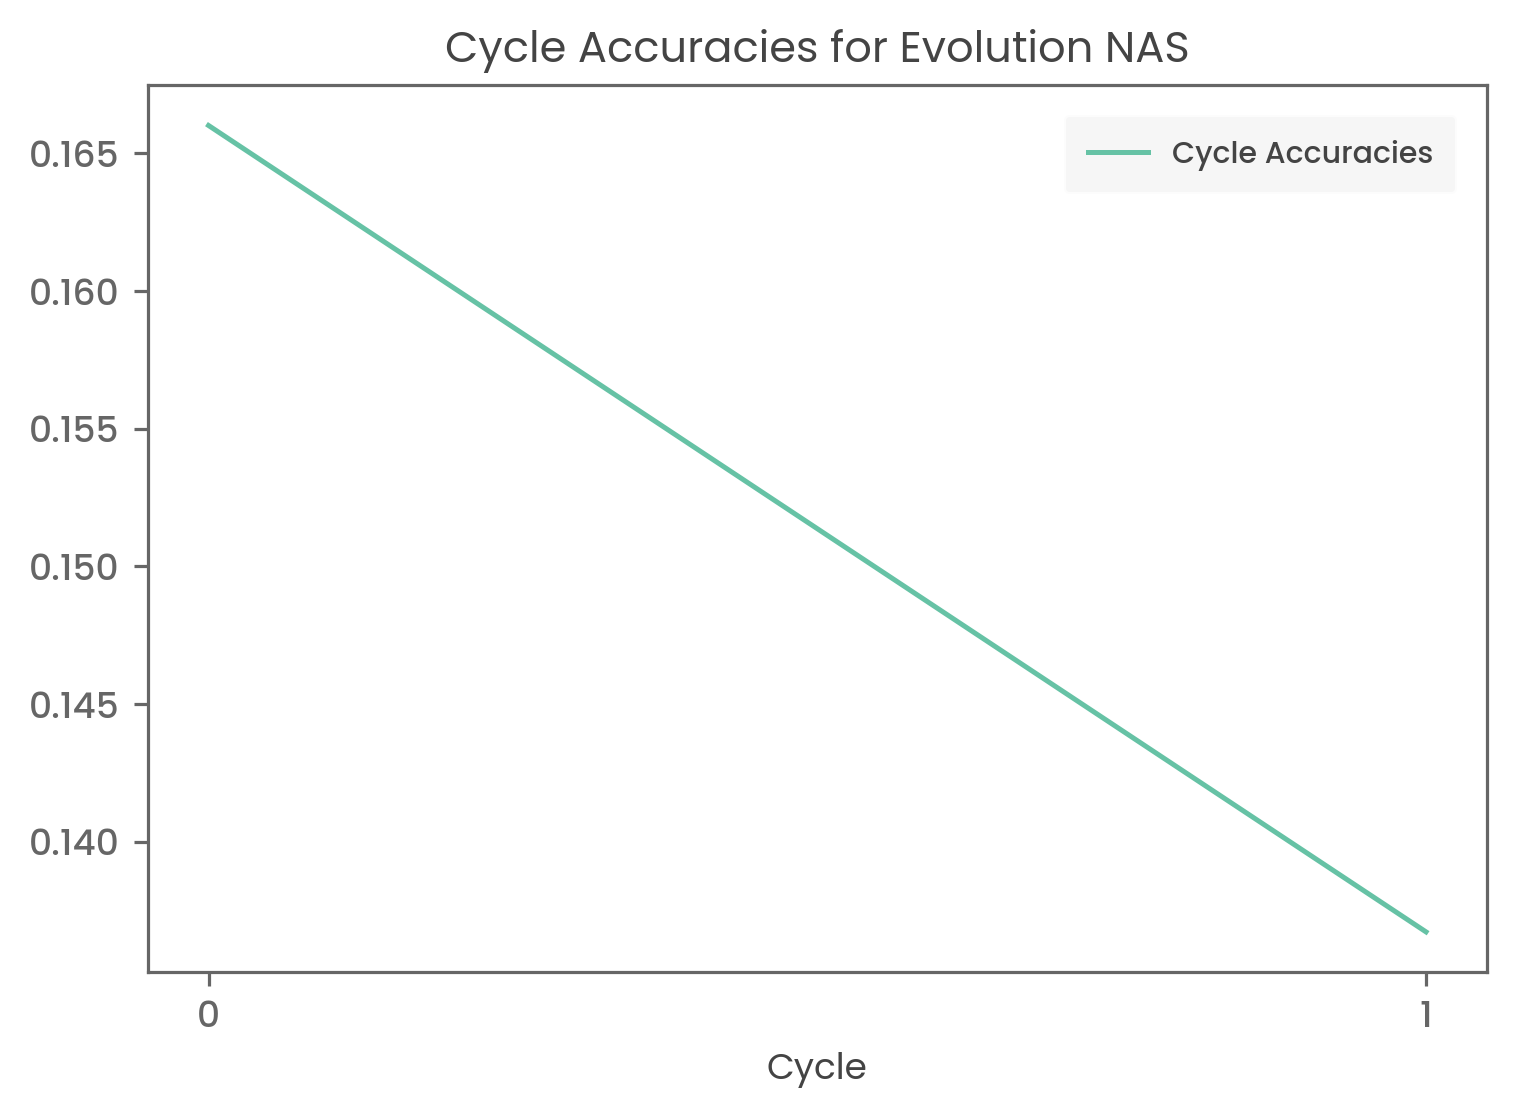

In [6]:

plt.plot(controller.best_accuracies, label='Cycle Accuracies')
plt.xlabel('Cycle')
plt.legend()
plt.title('Cycle Accuracies for Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

controller.best_accuracies

## Cell Visualization

In [3]:
class VisualCell(object):
    def __init__(self, state_space, config) -> None:
        self.state_space = state_space
        self.config = config
        self.palette = seaborn.color_palette("mako_r", 7).as_hex()

        self.G = nx.DiGraph()
        self.labels = {
            'input 0': 'input 0',
            'input 1': 'input 1',
            'concat_blocks': 'concat'
        }
        self.colors = {
            'input 0': self.palette[0],
            'input 1': self.palette[1],
            'concat_blocks': self.palette[5]
        }

        # Add input nodes
        for input_state in self.state_space[0]['values']:
            self.G.add_node(
                self.input_label(input_state),
                layer=0
            )

        # Add primary and combination nodes for blocks
        for nid in range(sum(map(lambda s: s['count'], self.state_space))*3):
            self.G.add_node(
                nid,
                layer=self.get_layer_id(nid)
            )

        # Add block combination node
        self.G.add_node('concat_blocks', layer=3)

    def input_label(self, idx) -> str:
        return 'input {}'.format(idx)

    def primary_op_label(self, idx) -> str:
        return self.state_space[1]['values'][idx].replace('_', '\n')

    def combination_op_label(self, idx) -> str:
        return STATE_SPACE[2]['values'][idx]

    def get_node_id(self, bid, item):
        return bid*3 + item

    def get_layer_id(self, nid) -> int:
        return 2 if (nid+1)%3 ==0 else 1

    def compose_block(self, bid, block):
        input_0, input_1, op_1, op_2, comb = block
        nid_op_0, nid_op_1 = self.get_node_id(bid, 0), self.get_node_id(bid, 1)
        nid_comb = self.get_node_id(bid, 2)

        # Add primary styles
        # self.labels[nid_op_0] = self.state_space[1]['values'][op_1]
        self.labels[nid_op_0] = self.primary_op_label(op_1)
        self.labels[nid_op_1] = self.primary_op_label(op_2)

        self.colors[nid_op_0] = self.palette[2]
        self.colors[nid_op_1] = self.palette[3]

        # Add combination styles
        self.labels[nid_comb] = self.state_space[2]['values'][comb]
        self.colors[nid_comb] = self.palette[4]

        # Add incoming edges for primary operations
        self.G.add_edge(
            self.input_label(input_0),
            self.get_node_id(bid, 0),
            color=self.palette[0]
        )
        self.G.add_edge(
            self.input_label(input_1),
            self.get_node_id(bid, 1),
            color=self.palette[1]
        )

        # Add incoming edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 0),
            self.get_node_id(bid, 2),
            color=self.palette[2]
        )
        self.G.add_edge(
            self.get_node_id(bid, 1),
            self.get_node_id(bid, 2),
            color=self.palette[3]
        )

        # Add outgoing edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 2),
            'concat_blocks',
            color=self.palette[4]
        )
    
    def draw(self, ax):
        # Process cell
        for bid in range(self.config.shape[0]):
            self.compose_block(bid, self.config[bid])

        # Create a multipartite layout to arrange inputs, primary
        # and combination operations in their respective layers.
        pos = nx.multipartite_layout(
            self.G,
            subset_key='layer',
            align='horizontal'
        )

        # Configure edge colors
        edge_colors = nx.get_edge_attributes(self.G,'color').values()

        # Draw cell structure
        nx.draw(
            self.G,
            pos=pos,
            node_color=list(map(lambda l: self.colors[l], self.G.nodes)),
            edge_color=edge_colors,
            node_size=list(map(lambda _:500, self.G.nodes)),
            ax=ax,
        )

        # Label cell operations
        nx.draw_networkx_labels(
            self.G,
            pos=pos,
            labels=self.labels,
            font_size=5,
            font_color=self.palette[6],
            ax=ax
        )

def visualize_cell(ax, config, title='Cell'):
    ax.set_title(title)

    visual = VisualCell(STATE_SPACE, config)
    visual.draw(ax)

accuracies = list(map(lambda child: child.accuracy, controller.histories))
num_selected_trials = 3
visual_size = 5
best_configs = list(map(
    lambda idx: controller.histories[idx].config,
    np.argsort(accuracies)[-num_selected_trials:][::-1]
))

figsize = (2*visual_size, len(best_configs)*visual_size)
fig, axes = plt.subplots(len(best_configs), 2, figsize=figsize)
for idx, c in enumerate(best_configs):
    visualize_cell(axes[idx, 0], c[0], 'Normal Cell')
    visualize_cell(axes[idx, 1], c[1], 'Reduction Cell')

best_configs

NameError: name 'controller' is not defined

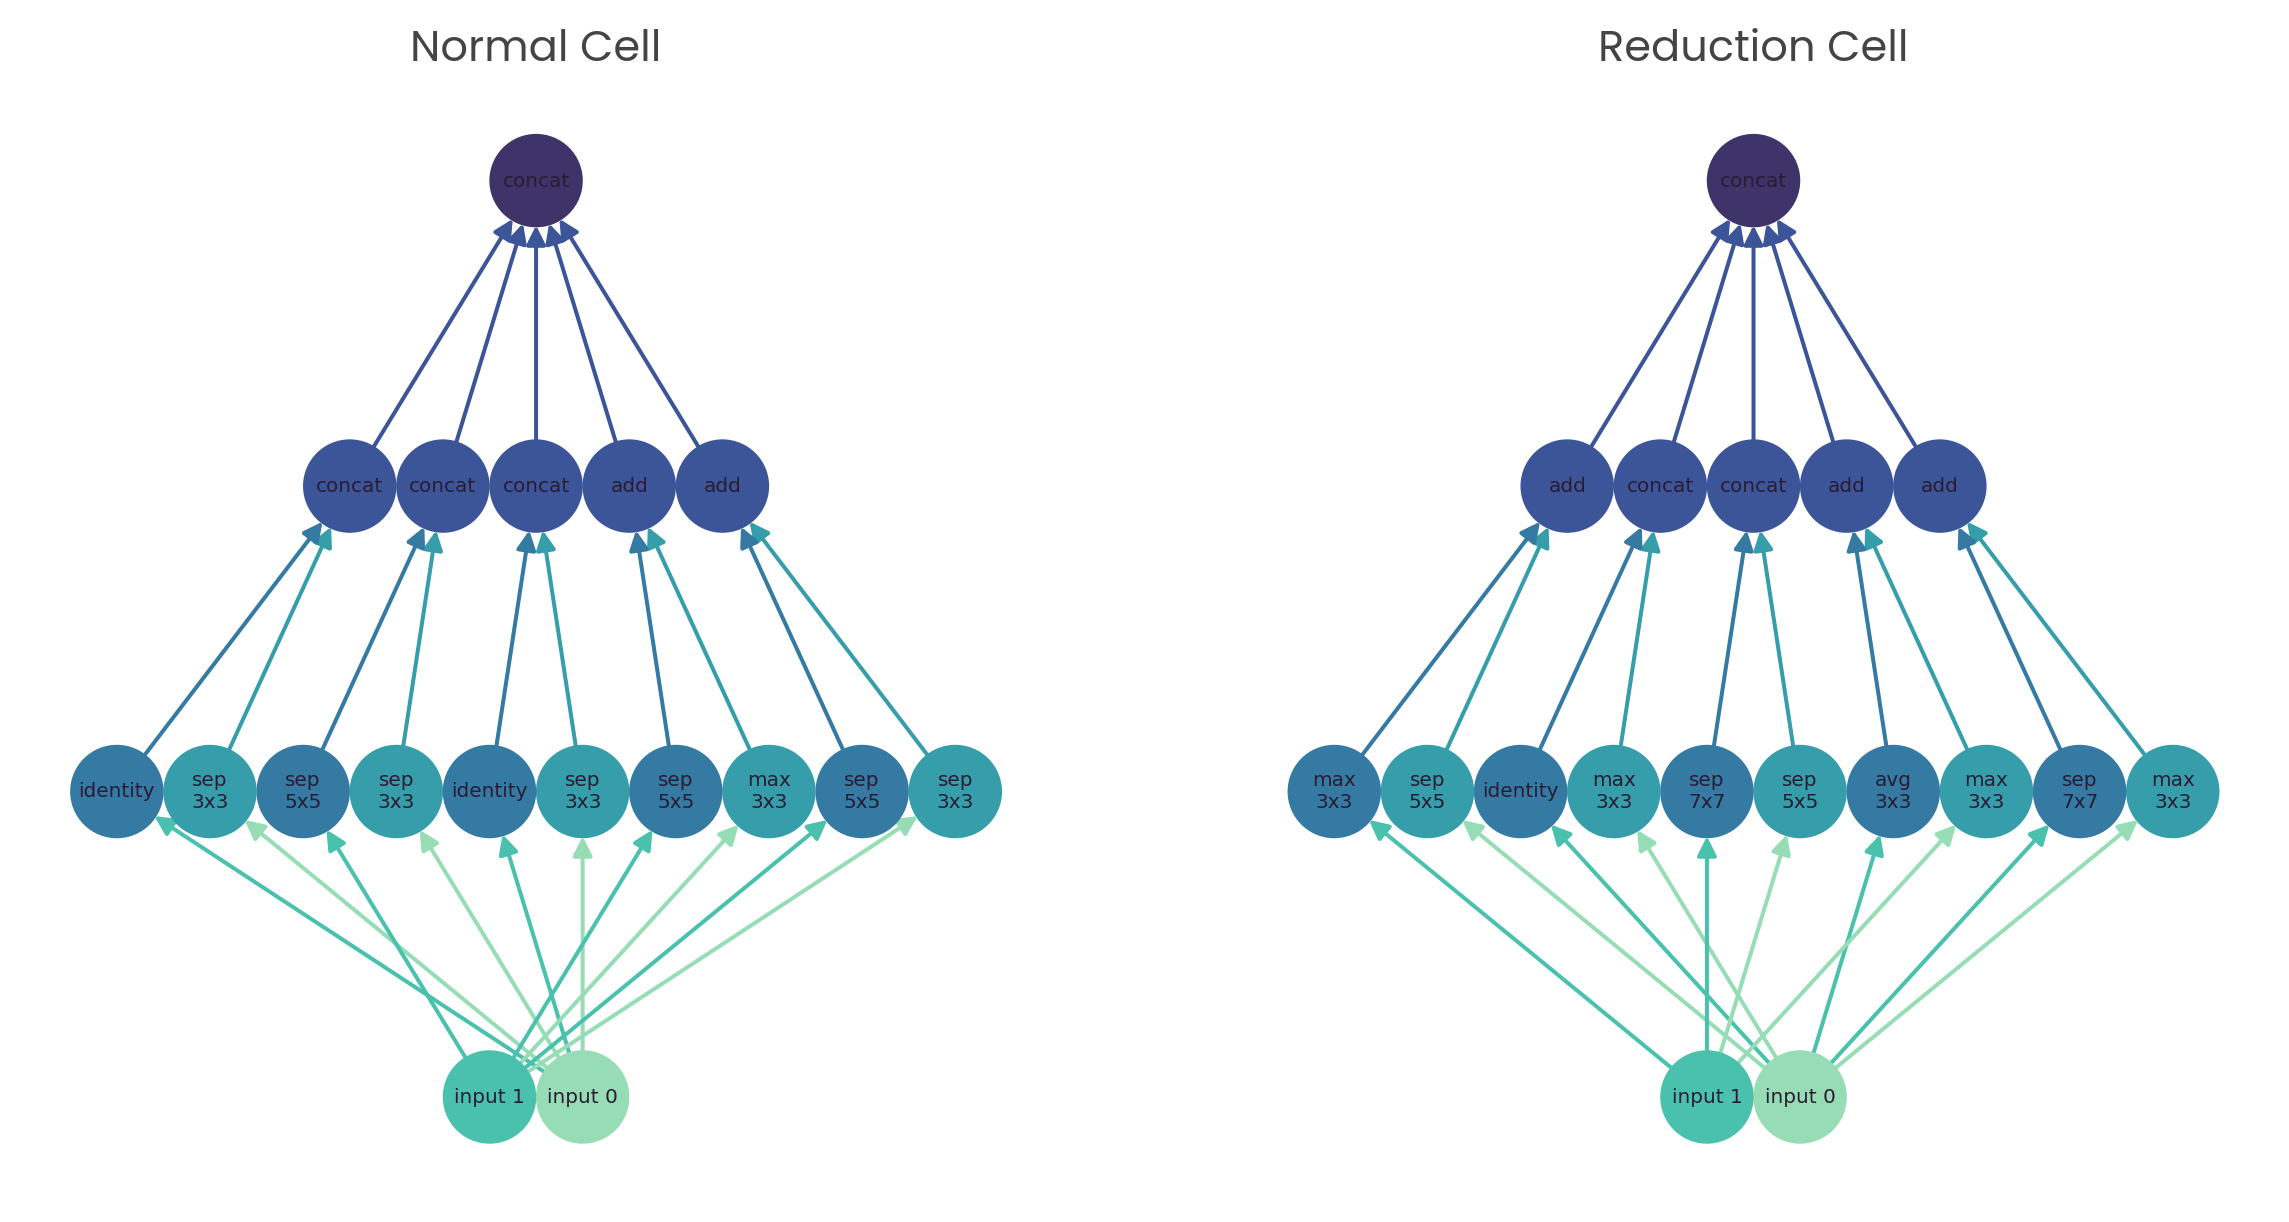

In [19]:
class VisualCell(object):
    def __init__(self, state_space, config) -> None:
        self.state_space = state_space
        self.config = config
        self.palette = seaborn.color_palette("mako_r", 7).as_hex()

        self.G = nx.DiGraph()
        self.labels = {
            'input 0': 'input 0',
            'input 1': 'input 1',
            'concat_blocks': 'concat'
        }
        self.colors = {
            'input 0': self.palette[0],
            'input 1': self.palette[1],
            'concat_blocks': self.palette[5]
        }

        # Add input nodes
        for input_state in self.state_space[0]['values']:
            self.G.add_node(
                self.input_label(input_state),
                layer=0
            )

        # Add primary and combination nodes for blocks
        for nid in range(sum(map(lambda s: s['count'], self.state_space))*3):
            self.G.add_node(
                nid,
                layer=self.get_layer_id(nid)
            )

        # Add block combination node
        self.G.add_node('concat_blocks', layer=3)

    def input_label(self, idx) -> str:
        return 'input {}'.format(idx)

    def primary_op_label(self, idx) -> str:
        return self.state_space[1]['values'][idx].replace('_', '\n')

    def combination_op_label(self, idx) -> str:
        return STATE_SPACE[2]['values'][idx]

    def get_node_id(self, bid, item):
        return bid*3 + item

    def get_layer_id(self, nid) -> int:
        return 2 if (nid+1)%3 ==0 else 1

    def compose_block(self, bid, block):
        input_0, input_1, op_1, op_2, comb = block
        nid_op_0, nid_op_1 = self.get_node_id(bid, 0), self.get_node_id(bid, 1)
        nid_comb = self.get_node_id(bid, 2)

        # Add primary styles
        # self.labels[nid_op_0] = self.state_space[1]['values'][op_1]
        self.labels[nid_op_0] = self.primary_op_label(op_1)
        self.labels[nid_op_1] = self.primary_op_label(op_2)

        self.colors[nid_op_0] = self.palette[2]
        self.colors[nid_op_1] = self.palette[3]

        # Add combination styles
        self.labels[nid_comb] = self.state_space[2]['values'][comb]
        self.colors[nid_comb] = self.palette[4]

        # Add incoming edges for primary operations
        self.G.add_edge(
            self.input_label(input_0),
            self.get_node_id(bid, 0),
            color=self.palette[0]
        )
        self.G.add_edge(
            self.input_label(input_1),
            self.get_node_id(bid, 1),
            color=self.palette[1]
        )

        # Add incoming edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 0),
            self.get_node_id(bid, 2),
            color=self.palette[2]
        )
        self.G.add_edge(
            self.get_node_id(bid, 1),
            self.get_node_id(bid, 2),
            color=self.palette[3]
        )

        # Add outgoing edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 2),
            'concat_blocks',
            color=self.palette[4]
        )
    
    def draw(self, ax):
        # Process cell
        for bid in range(self.config.shape[0]):
            self.compose_block(bid, self.config[bid])

        # Create a multipartite layout to arrange inputs, primary
        # and combination operations in their respective layers.
        pos = nx.multipartite_layout(
            self.G,
            subset_key='layer',
            align='horizontal'
        )

        # Configure edge colors
        edge_colors = nx.get_edge_attributes(self.G,'color').values()

        # Draw cell structure
        nx.draw(
            self.G,
            pos=pos,
            node_color=list(map(lambda l: self.colors[l], self.G.nodes)),
            edge_color=edge_colors,
            node_size=list(map(lambda _:500, self.G.nodes)),
            ax=ax,
        )

        # Label cell operations
        nx.draw_networkx_labels(
            self.G,
            pos=pos,
            labels=self.labels,
            font_size=5,
            font_color=self.palette[6],
            ax=ax
        )

state_space = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
#         values=['sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]
config = np.array([
    [
        [1, 1, 0, 1, 0],
        [1, 1, 4, 1, 0],
        [0, 0, 0, 5, 1],
        [0, 1, 0, 1, 1],
        [0, 0, 0, 5, 1],
    ],
    [
        [0, 0, 4, 2, 0],
        [1, 0, 4, 3, 0],
        [1, 1, 1, 2, 1],
        [0, 0, 4, 5, 1],
        [0, 1, 1, 4, 0],
    ]
])

def visualize_cell(ax, config, title='Cell'):
    ax.set_title(title)

    visual = VisualCell(state_space, config)
    visual.draw(ax)

visual_size = 5
figsize = (2*visual_size, visual_size)
fig, axes = plt.subplots(1, 2, figsize=figsize)

visualize_cell(axes[0], config[0], 'Normal Cell')
visualize_cell(axes[1], config[1], 'Reduction Cell')

In [63]:
state_space = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='primitives',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combinations', values=['add', 'concat'], count=1),
]

class StateSearchSpace(object):
    def __init__(self, name='state', choices=[], size=2, labels=[]) -> None:
        self.name = name
        self.choices = choices or list(range(size))
        self.labels = labels or self.choices
    
    def __str__(self) -> str:
        return '{}: {}'.format(
            self.name,
            self.labels
        )
    
    def __len__(self) -> int:
        return len(self.choices)
    
    def __getitem__(self, address):
        return self.choices[address]
    
    def random(self):
        return random.choice(list(range(len(self.choices))))
    
class BlockSearchSpace(object):
    def __init__(self) -> None:
        self.states = []
    
    def add_state(self, kwargs):
        state = StateSearchSpace(**kwargs)
        self.states.append(state)

        return state
    
    def __str__(self) -> str:
        return '\n'.join(map(str, self.states))
    
    def __len__(self) -> int:
        return len(self.states)
    
    def __getitem__(self, address):
        return self.states[address]
    
    def random(self):
        return np.array(list(
            map(lambda s: s.random(), self.states)
        ))

class CellSearchSpace(object):
    def __init__(self, block_search_space, blocks=1) -> None:
        self.block_search_space = block_search_space
        self.blocks = blocks
        self.cell_search_space = np.array(list(
            map(
                lambda _: list(map(lambda s: s.name, block_search_space.states)),
                range(blocks)
            )
        ))
    
    def __str__(self) -> str:
        return str(self.cell_search_space)
    
    def __len__(self) -> int:
        return self.cell_search_space.size
    
    def __getitem__(self, address):
        return self.cell_search_space[address]
    
    def toChoices(self, state):
        return np.array()

    
    def random(self):
        return np.array(list(
            map(
                lambda _: self.block_search_space.random(),
                range(self.blocks)
            )
        ))

# BLOCK_TIMESTEPS = 5
# CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
# TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
# STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

# TIMESTEP_ADDRESS_SPACE = (
#     CHILD_PARAMS['cells'],
#     CHILD_PARAMS['blocks'],
#     len(STATE_ID_TO_STATE_SPACE_ID)
# )
# TIMESTEP_ADDRESSES = np.stack(
#     np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
#     -1
# )

# STATE_ADDRESSES = list(map(
#     lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
#     TIMESTEP_ADDRESSES
# ))

def create_block_search_space():
    inputs = dict(name='inputs', size=2, labels=['input 0', 'input 1'])
    primitives = dict(
        name='primitives',
        choices=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity']
    )
    combinations = dict(
        name='combinations',
        choices=['add', 'concat']
    )

    block_search_space = BlockSearchSpace()
    states = list(map(
        block_search_space.add_state,
        [inputs, inputs, primitives, primitives, combinations]
    ))

    return block_search_space

block_search_space = create_block_search_space()
cell_search_space = CellSearchSpace(block_search_space, 5)
print('Normal Cell:\n', cell_search_space)
print('Block Search Space: ', len(block_search_space))
print('Cell Search Space: ', len(cell_search_space))

cell_search_space.random()

Normal Cell:
 [['inputs' 'inputs' 'primitives' 'primitives' 'combinations']
 ['inputs' 'inputs' 'primitives' 'primitives' 'combinations']
 ['inputs' 'inputs' 'primitives' 'primitives' 'combinations']
 ['inputs' 'inputs' 'primitives' 'primitives' 'combinations']
 ['inputs' 'inputs' 'primitives' 'primitives' 'combinations']]
Block Search Space:  5
Cell Search Space:  25


array([[0, 0, 4, 2, 0],
       [0, 0, 3, 2, 1],
       [0, 0, 3, 0, 0],
       [0, 0, 2, 2, 1],
       [1, 1, 3, 5, 1]])

In [116]:
N_ITERATIONS = 3
SURVIVAL_RATE = .7
REPRODUCTION_RATE = .5

def train_member(m):
#     result = m.model.fit(train_ds.batch(2).take(1))
    result = m
    return result

def natural_selection(p):
    def partition(items, size):
        shuffle(items) # In-place shuffle
        left, right = items[:size], items[size:]
        return left, right
    
    mc = len(p) # Member Count
    sc = floor(mc*SURVIVAL_RATE) # Survivals
    survivals, deaths = partition(list(range(mc)), sc) # Survivals and deaths
    
    # Transform survival and death indices to members 
    ids_to_members = lambda ids: list(map(lambda idx: p[idx], ids))
    survivals, _ = ids_to_members(survivals), ids_to_members(deaths)

    return survivals

def reproduction(p):
    def birth(parent):
        # Child Attributes
        parent_id, gen = parent.id, parent.gen+1 
        model = mds.clone_model(parent.model)
    
        child = init_member(parent=parent_id, gen=gen, model=model)
        return child
        
    mc = len(p) # Member Count
    pc = floor(mc*REPRODUCTION_RATE) # Parents
    parents = sample(list(range(mc)), pc)
    
    # Transform parent ids to parents
    parents = map(lambda idx: p[idx], parents)
    
    # Update population with new births
    p.extend(map(birth, parents))
    
    return p

def next_evolution(p):
    def update_member_gen(m):
        m.gen += 1
        return m
    
    # Natural Selection
    p = natural_selection(p)
    
#     # Increment Generation
#     p = list(map(update_member_gen, p))
    
    # Reproduction
    p = reproduction(p)
    
    # Evolve
    result = list(map(train_member, p))
    return result

def calculateDaysBetweenDates()

def run(p):
    result = None
    for step, iteration in enumerate(range(N_ITERATIONS)):
        p = next_evolution(p)
        print(step, p)
        result = p

    return result

run(POPULATION)

1